# Part I : Quel(le) data scientist êtes-vous ?

#### Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset Aquila, vous réaliserez :

    un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
    une prédiction des profils dont le métier n'est pas labellisé

#### Données

data.csv contient 6 variables : - 'Entreprise' correspond à une liste d'entreprises fictive - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte - 'Technologies' correspond aux compétences maîtrisées par le profil - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...) - 'Experience' correspond au nombre d'années d'expériences - 'Ville' correspond au lieu de travail

Répondez aux questions

Bonne chance!

# Part I : Quel(le) data scientist êtes-vous ?

In [1]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt
plt.style.use('ggplot')

## 1-) Importer le tableau de données dans un dataframe

In [2]:
# Import du dataframe "data.csv"
df = pd.read_csv('data.csv', sep = ",")

In [3]:
# Visualisation du dataset 

df

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux
...,...,...,...,...,...,...
9577,Massachusetts General Hospital(MGH),Data scientist,C++/R/Python/Matlab/Matplotlib,Master,"1,5",Lyon
9578,Charles River Analytics,Data scientist,Excel/Python/Matlab/R/machine learning/anglais,Master,11,Toulouse
9579,Ball Aerospace,Data scientist,R/machine learning/Excel/VBA,Master,1,Paris
9580,Takeda Pharmaceutical,Data scientist,Python/Pyspark/machine learning/Microsoft Azure,Master,17,Rennes


## 2- Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes?

In [4]:
# Visualisation du nombre d'observations dans ce dataset

print("Dans ce dataset, il y a {0:d} observations\n".format(df.shape[0]))

Dans ce dataset, il y a 9582 observations



In [5]:
# la taille des données

df.shape

(9582, 6)

In [6]:
# Les différents tailles des colonnes du dataset

df.count()

Entreprise      9565
Metier          9563
Technologies    9582
Diplome         9582
Experience      9488
Ville           9582
dtype: int64

In [7]:
# les différentes colonnes du dataset

df.columns

Index(['Entreprise', 'Metier', 'Technologies', 'Diplome', 'Experience',
       'Ville'],
      dtype='object')

In [8]:
# Les types de colonnes du dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Entreprise    9565 non-null   object
 1   Metier        9563 non-null   object
 2   Technologies  9582 non-null   object
 3   Diplome       9582 non-null   object
 4   Experience    9488 non-null   object
 5   Ville         9582 non-null   object
dtypes: object(6)
memory usage: 224.6+ KB


In [9]:
# Vérification des données manquantes pour chaque colonne

print(df.isnull().sum(axis = 0))

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64


Le nombre de valeurs manquantes pour chaque caractéristique, Pour *"Entreprise": on a 17 valeurs manquantes*, *"Metier":  on a 19 valeurs manquantes*, *"Experience" : on a 94 valeurs manquantes* , et *"Technologies", "Diplome", "Ville"* , il n'y a pas de valeurs manquantes

In [10]:
## Traitement des données sur le nombre d'années d'expérience, 
## Le but est de remplacer les "," par les "." par exemple "1,5" par "1.5"
## ET ensuite, changer le type "object" en "float

df['Experience'] = df['Experience'].astype(str)

df['Experience'] = [x.replace(",", ".") for x in df['Experience']]

df['Experience'] = df['Experience'].astype(float)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Entreprise    9565 non-null   object 
 1   Metier        9563 non-null   object 
 2   Technologies  9582 non-null   object 
 3   Diplome       9582 non-null   object 
 4   Experience    9488 non-null   float64
 5   Ville         9582 non-null   object 
dtypes: float64(1), object(5)
memory usage: 262.1+ KB


In [12]:
print("La somme des valeurs manquantes pour chaque caractéristiques est: ")
print(df.isna().sum())

La somme des valeurs manquantes pour chaque caractéristiques est: 
Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64


## 3- Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec :

  - la valeur médiane pour les data scientists
  - la valeur moyenne pour les data engineers


In [12]:
# On spécifie le dataset des metiers liés aux data scientists et aux data engineer

# Dataset pour les data scientists
data_DS = df['Metier'] == 'Data scientist'

# Dataset pour les data engineer
data_DE = df['Metier'] == 'Data engineer'

In [13]:
# Avant l'imputation, on vérifie d'abord la somme des valeurs manquantes pour les différents profils : Data Scientist et Data Engineer

print("Avant l\'imputation :\n")
print("La somme des valeurs manquantes de la variable Expérience pour le profil Data Scientist:"+str((df.loc[data_DS,'Experience']).isna().sum()))
print("La somme des valeurs manquantes de la variable Expérience pour le profil Data Engineer:"+str((df.loc[data_DE,'Experience']).isna().sum()))

Avant l'imputation :

La somme des valeurs manquantes de la variable Expérience pour le profil Data Scientist:32
La somme des valeurs manquantes de la variable Expérience pour le profil Data Engineer:20


In [14]:
# On remplit les valeurs manquantes de Data Engineers par la valeur moyenne

data_DE = df['Metier'] == 'Data engineer'
Mean_DE = df[data_DE]['Experience'].dropna().mean()
df.loc[data_DE, 'Experience'] = df.loc[data_DE, 'Experience'].fillna(Mean_DE)

In [15]:
# On remplit les valeurs manquantes de Data Scientists par la valeur médiane

data_DS = df['Metier'] == 'Data scientist'
Median_DS = df[data_DS]['Experience'].dropna().median()
df.loc[data_DS, 'Experience'] = df.loc[data_DS, 'Experience'].fillna(Median_DS)

In [16]:
# On vérifie les valeurs manquantes après l'imputation des valeurs manquantes pour les deux profils

print("\nAprés l\'imputation :\n")
print("La somme des valeurs manquantes de la variable Expérience pour le profil Data Scientist:"+str((df.loc[data_DS,'Experience']).isna().sum()))
print("La somme des valeurs manquantes de la variable Expérience pour le profil Data Engineer:"+str((df.loc[data_DE,'Experience']).isna().sum()))


Aprés l'imputation :

La somme des valeurs manquantes de la variable Expérience pour le profil Data Scientist:0
La somme des valeurs manquantes de la variable Expérience pour le profil Data Engineer:0


## 4-  Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

In [60]:
# remplire les valeurs manquantes de Data Scientist par la valeur moyenne

Mean_DS = df[data_DS]['Experience'].dropna().mean()
df.loc[data_DS, 'Experience'] = df.loc[data_DS, 'Experience'].fillna(Mean_DS)

# remplire les valeurs manquantes de Lead Data Scientist par la valeur moyenne

data_LDS = df['Metier'] == 'Lead data scientist'
Mean_LDS = df[data_LDS]['Experience'].dropna().mean()
df.loc[data_LDS, 'Experience'] = df.loc[data_LDS, 'Experience'].fillna(Mean_LDS)

# remplire les valeurs manquantes de Data Architecte par la valeur moyenne

data_DA = df['Metier'] == 'Data architecte'
Mean_DA = df[data_DA]['Experience'].dropna().mean()
df.loc[data_DA, 'Experience'] = df.loc[data_DA, 'Experience'].fillna(Mean_DA)

#Affichge
print("Les années d'experiences en moyenne pour chaque profil:\n")
print("Data scientist      : {0:f} ".format(Mean_DS))
print("Lead data scientist : {0:f} ".format(Mean_LDS))
print("Data enginner       : {0:f} ".format(Mean_DE))
#print("Data architecte     : {0:f} ".format(Mean_DA))

Les années d'experiences en moyenne pour chaque profil:

Data scientist      : 2.241268 
Lead data scientist : 3.965261 
Data enginner       : 2.984959 


## 5- Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

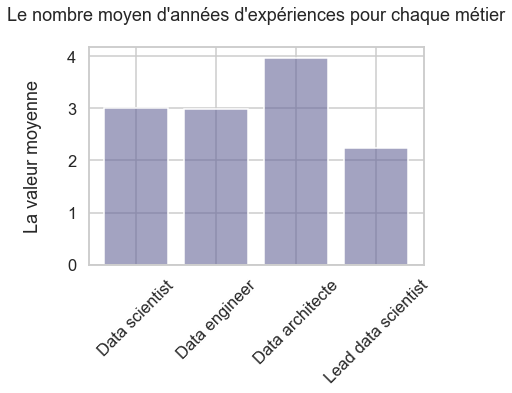

In [64]:
# Representation graphique du nombre moyen d'années d'expériences pour chaque métier

plt.figure()
plt.subplot(111)
X=df['Metier'].value_counts().keys()
Y=[Mean_DA, Mean_DE,Mean_LDS,Mean_DS]
plt.bar(X,Y,color=(0.4, 0.4, 0.6, 0.6))
sb.set_context("talk")
plt.xticks(X,rotation=45)
plt.ylabel("La valeur moyenne\n")
plt.title("Le nombre moyen d'années d'expériences pour chaque métier\n")
plt.show()

## 6- Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert

###### Veuillez expliquer votre choix du règle de transformation. 

In [42]:
# Transformons la variable continue "Experience" en une nouvelle variable catégorielle
## la fonction "cut" permet de regrouper l'expérience en 4 catégories : Débutant, Confirmé, Avancé et Expert

df['Exp_label']= pd.cut(df.Experience,4 , labels=['Debutant','Confirme','Avance','Expert'])
df

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris,Debutant
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille,Debutant
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes,Debutant
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille,Debutant
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.0,Bordeaux,Debutant
...,...,...,...,...,...,...,...
9577,Massachusetts General Hospital(MGH),Data scientist,C++/R/Python/Matlab/Matplotlib,Master,1.5,Lyon,Debutant
9578,Charles River Analytics,Data scientist,Excel/Python/Matlab/R/machine learning/anglais,Master,11.0,Toulouse,Avance
9579,Ball Aerospace,Data scientist,R/machine learning/Excel/VBA,Master,1.0,Paris,Debutant
9580,Takeda Pharmaceutical,Data scientist,Python/Pyspark/machine learning/Microsoft Azure,Master,17.0,Rennes,Expert


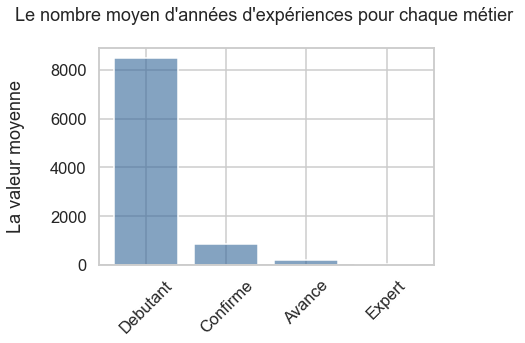

In [65]:
# Visualisation par un graphe des valeurs moyennes de différentes catégories

plt.figure()
plt.subplot(111)
X=df['Exp_label'].value_counts().keys()
Y=df['Exp_label'].value_counts().values
plt.bar(X,Y,color=(0.2, 0.4, 0.6, 0.6))
sb.set_context("talk")
plt.xticks(X,rotation=45)
plt.ylabel("La valeur moyenne\n")
plt.title("Le nombre moyen d'années d'expériences pour chaque métier \n")
plt.show()

On constate qu'il plus des débutants dans le métier que d'autres niveau d'expériences 

## 7- Quelles sont les 5 technologies les plus utilisées? Faites un graphique

In [44]:
## Les 5 technologies les plus utilisées

Top_5_technologies = df['Technologies'].value_counts()[0:5]
print(Top_5_technologies)

SQL/R/Python//Big data                                539
SAS/Teradata/SQL/R/Python/Machine learning/Anglais    458
C++/R/Python/Matlab/Matplotlib                        273
Hadoop/Hive/Vertica/Tableau                           250
SPSS/Excel/SAS/R/machine learning/AI/Scoring          250
Name: Technologies, dtype: int64


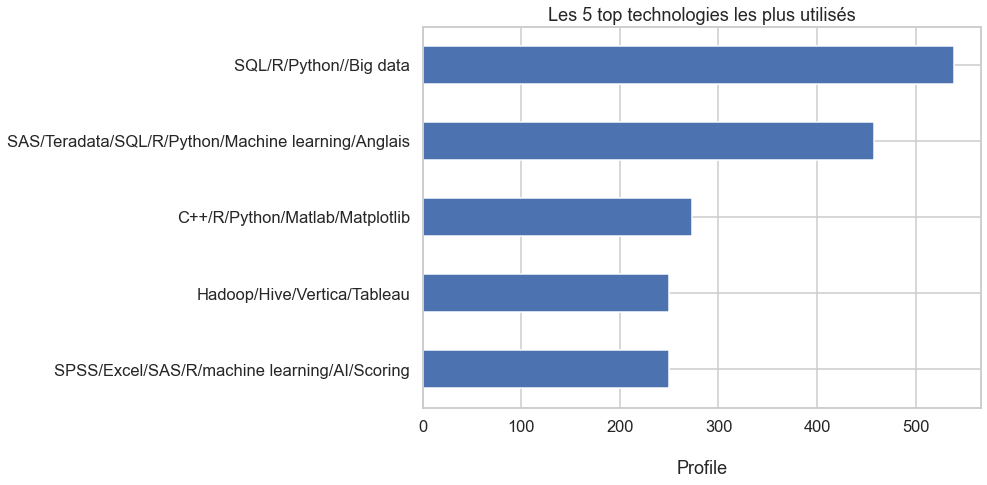

In [45]:
# Affichage de résultat par un graphique

ax = Top_5_technologies.plot(kind='barh', figsize=(10,7))
ax.invert_yaxis()
plt.xlabel("\nProfile")
plt.title('Les 5 top technologies les plus utilisés')
plt.show()

Les technologies *"SQL/R/Python/Big data"* sont plus utilisées dans le domaine

## 8 - Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.

  - Justifier la performance de votre algorithme grace à une métrique.
  - Interpréter votre resultat.


In [66]:
#

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_enc = df.loc[:,['Experience']]
df_enc['Ville_enc'] = pd.Series(le.fit_transform(np.squeeze(df.loc[:,['Ville']])[:]), index = df_enc.index)
df_enc['Technologies_enc'] = pd.Series(le.fit_transform(np.squeeze(df.loc[:,['Technologies']])[:]), index = df_enc.index)
df_enc['Diplome_enc'] = pd.Series(le.fit_transform(np.squeeze(df.loc[:,['Diplome']])[:]), index = df_enc.index)
df_enc['Exp_label_enc'] = pd.Series(le.fit_transform(np.squeeze(df.loc[:,['Exp_label']])[:]), index = df_enc.index)
df_enc = np.round(df_enc,2)
df_enc.head(5)

,Experience,Ville_enc,Technologies_enc,Diplome_enc,Exp_label_enc
0,1.0,8,27,1,2
1,3.0,4,34,1,2
2,3.0,6,51,1,2
3,1.5,4,2,1,2
4,2.0,0,26,3,2


La méthode choisie pour le clustering est K-Means, pour sa simplicité et la connaissance du nombre de cluster =2

In [67]:
# Importation des librairies pour les KMeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

X = df_enc.astype(float)

# feature scaling with MinMaxscaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=2, max_iter = 100, algorithm = 'auto')
kmeans.fit(X_scaled)
labels_ = kmeans.labels_
c1, c2 = kmeans.cluster_centers_

In [68]:
# Evaluation se fait en calculant l'erreur moyenne quadratique : NMSE (Normalized Mean Square Error)
# Evaluation de l'erreur de clustering pour chaque cluster

NMSE = lambda a,b: 100 * ((a-b)**2).sum() / ((a)**2).sum()
NMSE_1 = NMSE(X_scaled[labels_==0], c1) 
NMSE_2 = NMSE(X_scaled[labels_==1], c2)
print(' NMSE  cluster 1: {0:2.2f}%'.format(NMSE_1))
print(' NMSE  cluster 2: {0:2.2f}%'.format(NMSE_2))

 NMSE  cluster 1: 11.85%
 NMSE  cluster 2: 19.21%


Les erreurs moyennes quadratiques normalisées pour les deux clusteres sont moins de 20%.

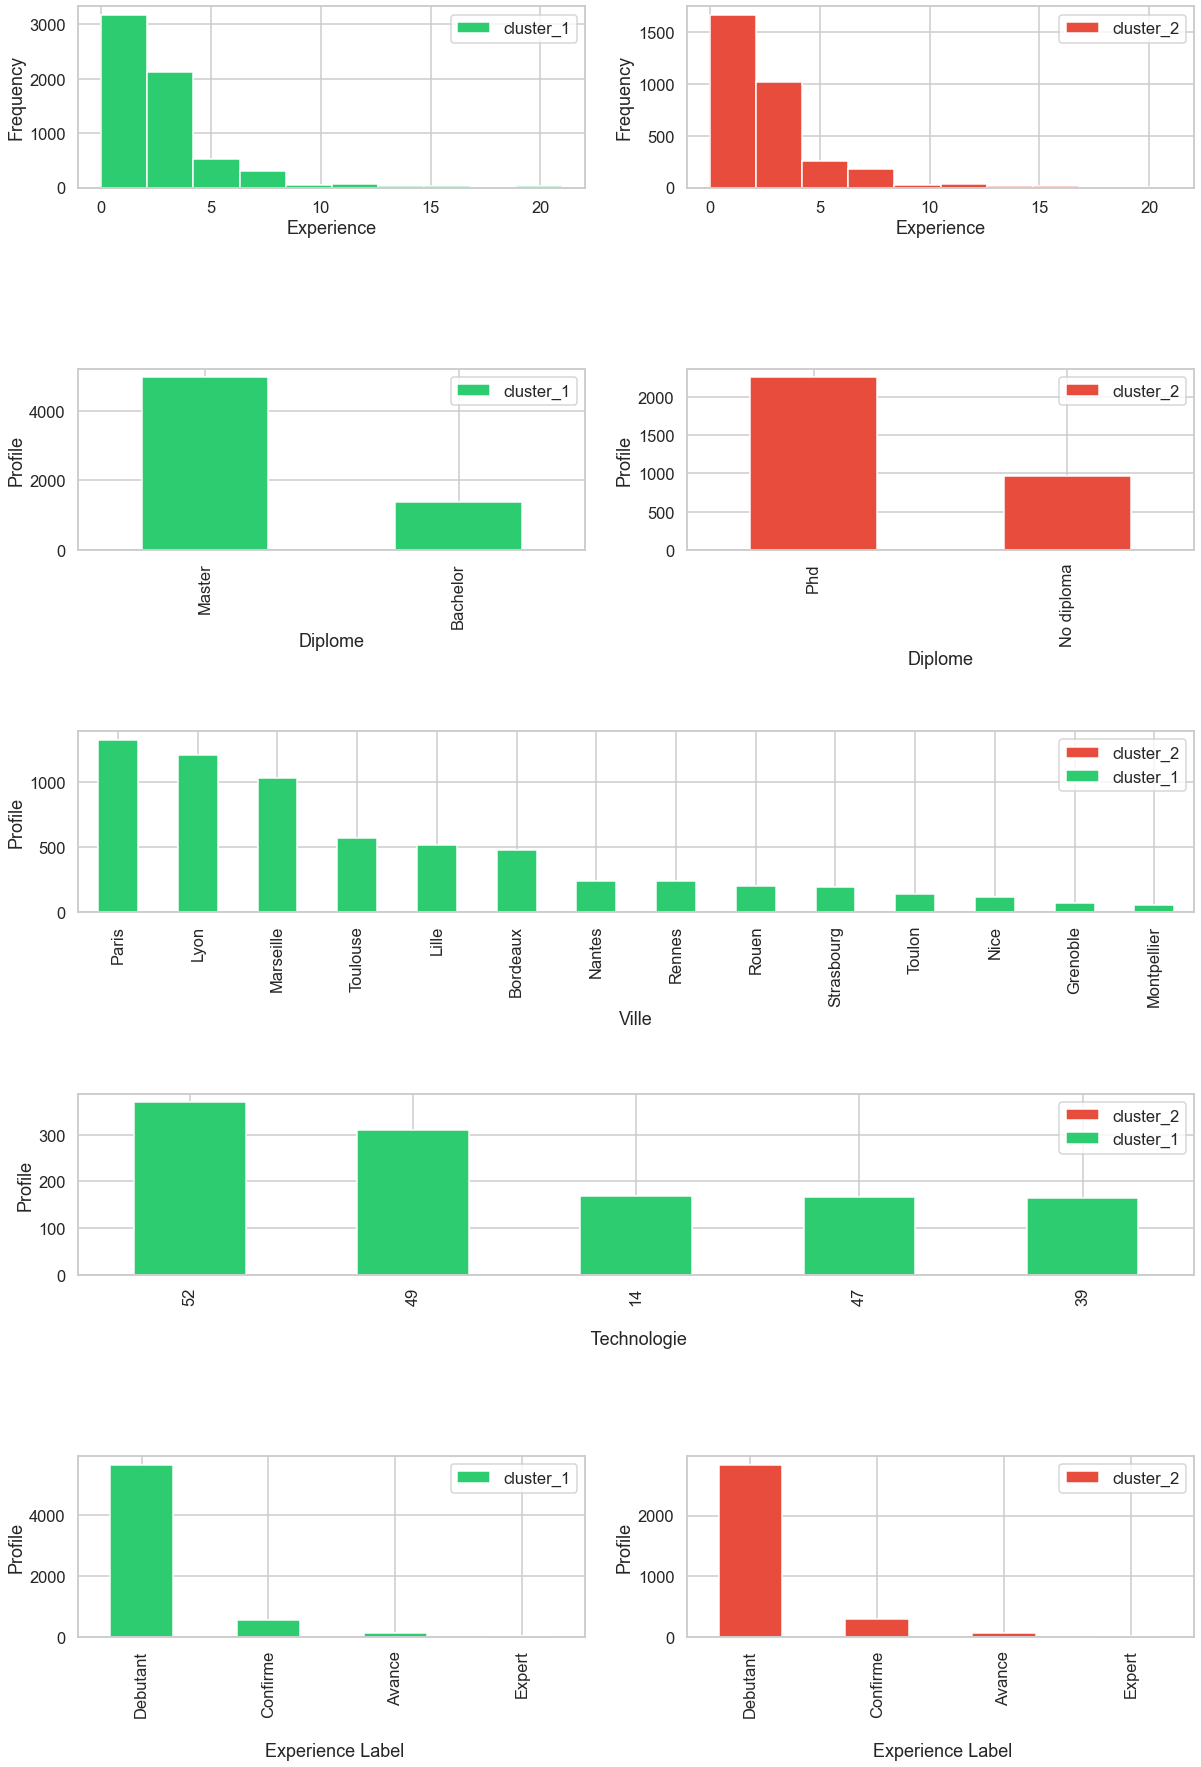

In [69]:
plt.figure(figsize=(20,30))
plt.subplot(521),
ax = df_enc.loc[labels_==1,'Experience'].plot(kind='hist', color='#2ecc71', label='cluster_1')
plt.legend()
plt.xlabel("Experience")
plt.subplot(522),
ax = df_enc.loc[labels_==0,'Experience'].plot(kind='hist', color='#e74c3c', label='cluster_2')
plt.xlabel("Experience")
plt.legend()

plt.subplot(523),
ax = df.loc[labels_==1,'Diplome'].value_counts().plot(kind='bar', color='#2ecc71', label='cluster_1')
plt.xlabel("Diplome")
plt.ylabel("Profile")
plt.legend()

plt.subplot(524),
ax = df.loc[labels_==0,'Diplome'].value_counts().plot(kind='bar', color='#e74c3c', label='cluster_2')
plt.xlabel("Diplome")
plt.ylabel("Profile")
plt.legend()

plt.subplot(513),
ax = df.loc[labels_==0,'Ville'].value_counts().plot(kind='bar', color = '#e74c3c', label='cluster_2')
ax = df.loc[labels_==1,'Ville'].value_counts().plot(kind='bar', color = '#2ecc71', label='cluster_1')
plt.ylabel("Profile")
plt.xlabel("Ville")
plt.legend()

plt.subplot(514),
ax = df_enc.loc[labels_==0,'Technologies_enc'].value_counts()[0:5].plot(kind='bar', color = '#e74c3c', label='cluster_2')
ax = df_enc.loc[labels_==1,'Technologies_enc'].value_counts()[0:5].plot(kind='bar', color = '#2ecc71', label='cluster_1')
plt.ylabel("Profile")
plt.xlabel("\n Technologie")
plt.legend()

plt.subplot(529)
ax=df.loc[labels_==1,'Exp_label'].value_counts().plot(kind='bar', color='#2ecc71', label='cluster_1')
plt.ylabel("Profile")
plt.xlabel("\n Experience Label")
plt.legend()
plt.subplot(5,2,10)
ax=df.loc[labels_==0,'Exp_label'].value_counts().plot(kind='bar', color='#e74c3c', label='cluster_2')
plt.ylabel("Profile")
plt.xlabel("\n Experience Label")
plt.legend()

plt.subplots_adjust(hspace=1)

plt.show()

#### Les caracteristiques les plus imortantes des deux clusteres sont :  le Diplome et l'Experience:

- Première Caractérstique est le Diplome :

    Cluster 1 : No diplome et PhD.
    Cluster 2 : Master et Bachelor.
     
    
- Deuxièmes Caractérstique est l'Expérience :

    Le nombre d'année d'Experience des profiles du premier cluster est beaucoup plus élevés par rapport aux profiles du deuxieme cluster.

## 9- Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix

 - Justifier la performance de votre algorithme grace à une métrique.
 - Interpréter votre resultat.


In [70]:
## Importation des librairies importantes pour le modèle prédictif
from sklearn import model_selection
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [71]:
data_metier = df.loc[:,'Metier'].isna()
# Préparation de la base de donnée sans métier nulle
X = np.array(df_enc[~data_metier])
y = le.fit_transform(df.loc[~data_metier,'Metier'].dropna())
#Metier_na contient les donnée avec la caractéristique du metier est nulle.
Metier_na = np.array(df_enc[data_metier])
#Diviser les données 80% pour l'entrainement et 20% pour le test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.20, shuffle=True , random_state=40)

###### 1. Premier model SVM

In [72]:
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [81]:
mvs = svm.SVC()

In [82]:
modele1 = mvs.fit(X_train,y_train)

In [83]:
y_pred1 = modele1.predict(X_test)

In [84]:
print('Matrice de confusion :\n')
print(metrics.confusion_matrix(y_test,y_pred1))

print('\nLe rapport de classificiation :\n')
print(classification_report(y_test,y_pred1))

Matrice de confusion :

[[391  40   8   0]
 [ 87 327  19   0]
 [  8  11 725  49]
 [  2   4 156  86]]

Le rapport de classificiation :

             precision    recall  f1-score   support

          0       0.80      0.89      0.84       439
          1       0.86      0.76      0.80       433
          2       0.80      0.91      0.85       793
          3       0.64      0.35      0.45       248

avg / total       0.79      0.80      0.79      1913



In [85]:
print("La précision :"+str(metrics.accuracy_score(y_test,y_pred1)*100)+' %')

La précision :79.92681651855725 %


###### 2. Second model KNN

In [78]:
model = KNeighborsClassifier(n_neighbors=4).fit(X_train,y_train)

In [79]:
y_predicted = model.predict(X_test)
cm = confusion_matrix(y_test, y_predicted) 
print('Matrice de confusion :\n')
print(cm)
print('\nLe rapport de classificiation :\n')
print(classification_report(y_test,y_predicted))

Matrice de confusion :

[[398  30   9   2]
 [ 64 352  15   2]
 [ 20  28 694  51]
 [  7   6 149  86]]

Le rapport de classificiation :

             precision    recall  f1-score   support

          0       0.81      0.91      0.86       439
          1       0.85      0.81      0.83       433
          2       0.80      0.88      0.84       793
          3       0.61      0.35      0.44       248

avg / total       0.79      0.80      0.79      1913



In [80]:
print("La précision :"+str(accuracy_score(y_test, y_predicted)*100)+' %')

La précision :79.9790904338735 %


Aprés une comparaison de trois modéles de Machine Learning relativement à la métrique de la précision, j'ai choisi le modéle (les K plus proches voisins) qui a la précision la plus élevé pour la prédicition des métiers manquants

In [86]:
#warnings.filterwarnings(action='ignore', category=DeprecationWarning)
#Prédicition les métiers manquants par notre modéle des k-plus proches voisins
Metier_predicted=model.predict(Metier_na)

#Remplissage de la base de données par les métiers prédits après la transformation inverse (Code to String) 
df.loc[~data_metier, 'Metier_predicted'] = df.loc[:,'Metier']
df.loc[data_metier, 'Metier_predicted'] = le.inverse_transform(Metier_predicted)

#Affichage
print("Le résultat de la prediction des métiers manquants est obtenu à l'aide d'une classification des données avec le model de k- plus proches voisins:\n")
df[data_metier]

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Le résultat de la prediction des métiers manquants est obtenu à l'aide d'une classification des données avec le model de k- plus proches voisins:



,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label,Metier_predicted
346,Jacobs,NaN,Python/Spark/GNU/Linux,No diploma,2.5,Paris,Debutant,Data engineer
2058,Ball Aerospace,NaN,VBA/Python/Excel/R,Master,15.0,Lyon,Avance,Data engineer
2670,"eHire, LLC",NaN,Java/C/C++/R/Python,Master,1.5,Toulouse,Debutant,Data scientist
2899,Norfolk Southern Corp,NaN,Python/Tensorflow/scikit-learn/Deep learning/R,Phd,0.0,Grenoble,Debutant,Data scientist
3346,J.E. Ranta Associates,NaN,Cassandra/MongoDB/NoSQL/AWS,Master,7.0,Rennes,Confirme,Data engineer
4248,KPMG,NaN,Python/Microsoft Azure/R/SQL,Phd,2.0,Lyon,Debutant,Data scientist
4290,"Pandora Media, Inc.",NaN,SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Phd,1.5,Toulouse,Debutant,Data scientist
4292,Partners HealthCare(PHS),NaN,SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Master,8.0,Bordeaux,Confirme,Lead data scientist
5425,Ashton Lane Group,NaN,Python/Pyspark/Spark,No diploma,5.0,Lyon,Debutant,Data engineer
5593,Lighthouse Lab Services,NaN,Python/R/machine learning/Excel/VBA/C++,Master,3.0,Lyon,Debutant,Data scientist
